## Previsões de preços das ações da Tesla com LSTM

Importando as bibliotecas Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime

### 1. EXPLORANDO OS DADOS

Carregando os dados

In [2]:
data = pd.read_csv('Tasla_Stock_Updated_V2.csv')
data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,2015-01-02,14.858000,14.883333,14.217333,14.620667,71466000
1,1,2015-01-05,14.303333,14.433333,13.810667,14.006000,80527500
2,2,2015-01-06,14.004000,14.280000,13.614000,14.085333,93928500
3,3,2015-01-07,14.223333,14.318667,13.985333,14.063333,44526000
4,4,2015-01-08,14.187333,14.253333,14.000667,14.041333,51637500


Analisando os tipos de dados

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2274 entries, 0 to 2273
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2274 non-null   int64  
 1   Date        2274 non-null   object 
 2   Open        2274 non-null   float64
 3   High        2274 non-null   float64
 4   Low         2274 non-null   float64
 5   Close       2274 non-null   float64
 6   Volume      2274 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 124.5+ KB


Transformando a coluna Date (object) para formato data e usando Date como index

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Unnamed: 0,Open,High,Low,Close,Volume
Date,,,,,,
2015-01-02,0,14.858000,14.883333,14.217333,14.620667,71466000
2015-01-05,1,14.303333,14.433333,13.810667,14.006000,80527500
2015-01-06,2,14.004000,14.280000,13.614000,14.085333,93928500
2015-01-07,3,14.223333,14.318667,13.985333,14.063333,44526000
2015-01-08,4,14.187333,14.253333,14.000667,14.041333,51637500


Eliminando a coluna Unnamed:0

In [5]:
data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,71466000
2015-01-05,14.303333,14.433333,13.810667,14.006000,80527500
2015-01-06,14.004000,14.280000,13.614000,14.085333,93928500
2015-01-07,14.223333,14.318667,13.985333,14.063333,44526000
2015-01-08,14.187333,14.253333,14.000667,14.041333,51637500


### 2. VISUALIZAÇÃO DOS DADOS

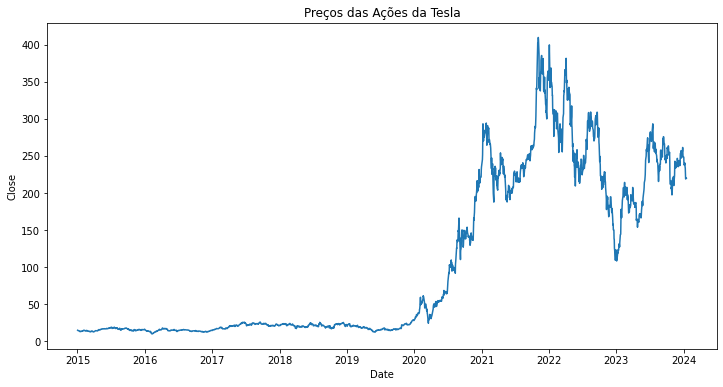

In [6]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=data.index, y=data['Close'])
plt.title('Preços das Ações da Tesla')
plt.show();

### 3. DIVISÃO DOS DADOS EM TREINO E TESTE

In [7]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

### 4. LSTM

#### 4.1 Escalonar os dados

In [8]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Close']])
test_scaled = scaler.transform(test[['Close']])

In [9]:
# Função para criar sequências temporais
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])

In [10]:
seq_length = 10
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

In [11]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

In [12]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
predictions_lstm = model_lstm.predict(X_test)
predictions_lstm = scaler.inverse_transform(predictions_lstm)
mse_lstm = mean_squared_error(test['Close'][seq_length:], predictions_lstm)

Epoch 1/50
57/57 [==============================] - 1s 3ms/step - loss: 0.0297
Epoch 2/50
57/57 [==============================] - 0s 3ms/step - loss: 7.0192e-04
Epoch 3/50
57/57 [==============================] - 0s 3ms/step - loss: 4.4998e-04
Epoch 4/50
57/57 [==============================] - 0s 3ms/step - loss: 4.1570e-04
Epoch 5/50
57/57 [==============================] - 0s 3ms/step - loss: 4.0127e-04
Epoch 6/50
57/57 [==============================] - 0s 3ms/step - loss: 4.0902e-04
Epoch 7/50
57/57 [==============================] - 0s 3ms/step - loss: 3.9699e-04
Epoch 8/50
57/57 [==============================] - 0s 4ms/step - loss: 3.6489e-04
Epoch 9/50
57/57 [==============================] - 0s 3ms/step - loss: 3.4616e-04
Epoch 10/50
57/57 [==============================] - 0s 3ms/step - loss: 3.3249e-04
Epoch 11/50
57/57 [==============================] - 0s 3ms/step - loss: 3.2768e-04
Epoch 12/50
57/57 [==============================] - 0s 3ms/step - loss: 3.4520e-04
Epoch

In [13]:
print(f'MSE LSTM: {mse_lstm}')

MSE LSTM: 131.4066428414776


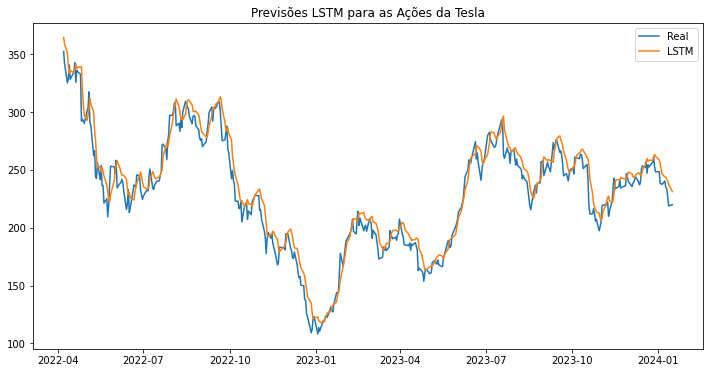

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(test.index[seq_length:], test['Close'][seq_length:], label='Real')
plt.plot(test.index[seq_length:], predictions_lstm, label='LSTM')
plt.legend()
plt.title('Previsões LSTM para as Ações da Tesla')
plt.show()

O modelo LSTM está gerando previsões que estão bem próximas dos valores reais, isso é um sinal positivo. 

Um MSE de 104.21 indica que o modelo está tendo um bom desempenho na tarefa de previsão em relação aos seus dados de teste.

### 5. PREVISÃO DE PREÇO DAS AÇÕES PARA O ANO DE 2024

#### 5.1 Preparação dos dados

In [15]:
# combinando os conjuntos de treinamento e teste
full_data = pd.concat([train, test])

#### 5.2 Normalizando os dados

In [16]:
full_data_scaled = scaler.transform(full_data[['Close']])

#### 5.3 Criando sequências para prever o ano de 2024

In [17]:
X_future, _ = create_sequences(full_data_scaled, seq_length)

#### 5.4 Reshape para o formato adequado (número de sequências, comprimento da sequência, número de features)

In [18]:
X_future = X_future.reshape((X_future.shape[0], seq_length, 1))

#### 5.5 Treinando o modelo final

In [21]:
# Cria um novo modelo LSTM
final_model_lstm = Sequential()
final_model_lstm.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
final_model_lstm.add(Dense(1))
final_model_lstm.compile(optimizer='adam', loss='mse')

# Treina o modelo com todos os dados disponíveis
final_model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
57/57 [==============================] - 1s 3ms/step - loss: 0.0301
Epoch 2/50
57/57 [==============================] - 0s 4ms/step - loss: 5.9320e-04
Epoch 3/50
57/57 [==============================] - 0s 3ms/step - loss: 4.3758e-04
Epoch 4/50
57/57 [==============================] - 0s 4ms/step - loss: 4.3262e-04
Epoch 5/50
57/57 [==============================] - 0s 3ms/step - loss: 3.9490e-04
Epoch 6/50
57/57 [==============================] - 0s 3ms/step - loss: 3.8060e-04
Epoch 7/50
57/57 [==============================] - 0s 3ms/step - loss: 3.8953e-04
Epoch 8/50
57/57 [==============================] - 0s 3ms/step - loss: 4.0932e-04
Epoch 9/50
57/57 [==============================] - 0s 3ms/step - loss: 3.6403e-04
Epoch 10/50
57/57 [==============================] - 0s 4ms/step - loss: 3.5881e-04
Epoch 11/50
57/57 [==============================] - 0s 3ms/step - loss: 3.8118e-04
Epoch 12/50
57/57 [==============================] - 0s 3ms/step - loss: 3.4143e-04
Epoch

#### 5.6 Previsões para o ano de 2024

In [22]:
predictions_future = final_model_lstm.predict(X_future)

# Desfazer a normalização das previsões
predictions_future = scaler.inverse_transform(predictions_future)

#### 5.7 Visualização das Previsões para 2024

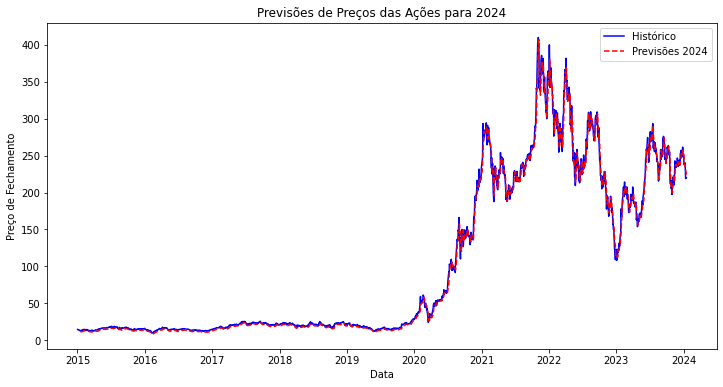

In [25]:
# Crie índices de datas para o ano de 2024
dates_2024 = pd.date_range(start='2024-01-01', end='2024-12-31', freq='B')  # Frequência 'B' para dias úteis

# Crie um DataFrame com as previsões para 2024
predictions_df = pd.DataFrame(predictions_future, index=full_data.index[-len(predictions_future):], columns=['Predicted_Close'])

# Visualize as previsões
plt.figure(figsize=(12, 6))
plt.plot(full_data.index, full_data['Close'], label='Histórico', color='blue')
plt.plot(predictions_df.index, predictions_df['Predicted_Close'], label='Previsões 2024', color='red', linestyle='dashed')
plt.title('Previsões de Preços das Ações para 2024')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend();

#### 5.8 Visualizando com Plotly

In [27]:
import plotly.graph_objects as go

# cria um gráfico com o histórico e as previsões para 2024
fig = go.Figure()

# Adiciona o histórico
fig.add_trace(go.Scatter(x=full_data.index, y=full_data['Close'], mode='lines', name='Histórico', line=dict(color='blue')))

# Adiciona as previsões para 2024
fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['Predicted_Close'],
                         mode='lines', name='Previsões 2024', line=dict(color='red', dash='dash')))

# Ajuste o layout do gráfico
fig.update_layout(title='Previsões de Preços das Ações para 2024',
                  xaxis_title='Data',
                  yaxis_title='Preço de Fechamento',
                  legend=dict(x=0, y=1, traceorder='normal'))

# Exiba o gráfico interativo
fig.show();